## IMPORTS

In [1]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
import numpy as np
import pandas as pd
from sklearn import svm,model_selection
from sklearn.linear_model import LogisticRegression
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
 
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score,accuracy_score,confusion_matrix,roc_curve,f1_score,auc,precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import scipy.sparse as sparse
from numpy import array


Using TensorFlow backend.
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# READ CSV

In [2]:
df=pd.read_csv('cardio_train.csv',sep=';')
df['age']=(df['age']/365).round().astype('int')
df.drop(['id'],axis=1,inplace=True)
df['BMI'] = df['weight']/((df['height']/100)**2)


In [3]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


## DATA ANALYSIS

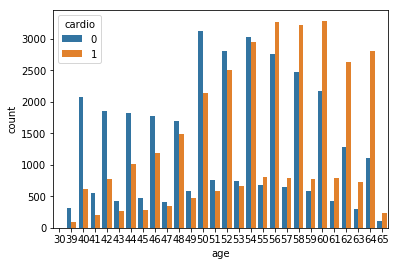

In [9]:
sns.countplot(data=df, x=df.age, hue=df.cardio)

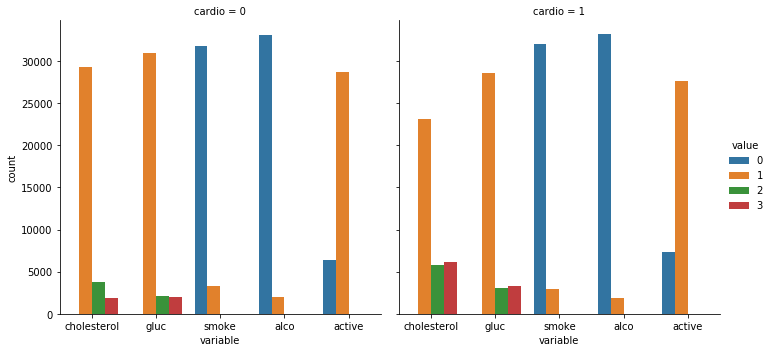

In [10]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

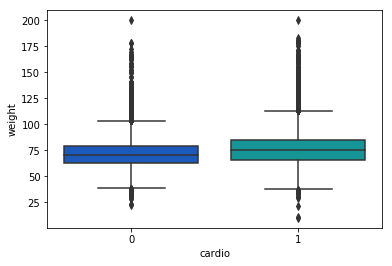

In [11]:
sns.boxplot(x='cardio',y='weight',data=df,palette='winter')

# DATA PREPROCESSING

In [4]:
df.isnull().values.any()

False

In [5]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [3]:
df[df.ap_lo>df.ap_hi]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
228,48,2,183,98.0,160,1100,1,2,1,0,1,1,29.263340
241,60,2,157,60.0,160,1000,2,1,0,0,0,1,24.341758
260,50,1,150,83.0,140,800,1,1,0,0,1,1,36.888889
329,64,1,176,63.0,160,1000,2,2,0,0,0,1,20.338326
345,51,1,154,81.0,140,1000,2,1,0,0,1,1,34.154158
473,42,1,150,95.0,150,1033,1,1,0,0,1,1,42.222222
474,52,1,156,65.0,120,150,2,1,0,0,1,0,26.709402
559,56,2,173,101.0,200,1000,1,1,0,0,1,1,33.746533
567,58,1,168,78.0,14,90,2,1,0,0,1,1,27.636054
613,52,1,165,92.0,140,1000,1,1,1,0,1,1,33.792470


In [21]:
df.sort_values('BMI')

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
54675,54,1,161,50.0,100,70,0,0,1,0,19,1,0,0,0,0,1
15429,64,0,165,53.0,130,80,1,0,1,0,19,1,0,0,1,0,0
3248,52,0,167,54.0,110,70,1,0,1,0,19,1,0,0,0,1,0
20534,50,1,175,59.0,110,70,0,0,1,0,19,1,0,0,1,0,0
55275,54,0,167,54.0,120,80,0,0,1,0,19,1,0,0,1,0,0
5562,46,1,170,56.0,120,80,0,0,0,0,19,1,0,0,1,0,0
64790,58,1,157,48.0,100,60,0,0,1,0,19,1,0,0,1,0,0
67603,47,1,170,56.0,100,70,0,0,1,0,19,1,0,0,1,0,0
20541,43,0,165,53.0,130,70,1,0,0,1,19,0,1,0,0,1,0
45152,40,1,159,49.0,100,60,0,0,1,0,19,1,0,0,1,0,0


In [42]:
df.drop(df[(df['height'] > df['height'].quantile(0.99)) | (df['height'] < df['height'].quantile(0.01))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.99)) | (df['weight'] < df['weight'].quantile(0.01))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.99)) | (df['ap_hi'] < df['ap_hi'].quantile(0.01))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.99)) | (df['ap_lo'] < df['ap_lo'].quantile(0.01))].index,inplace=True)

df = df[df.ap_hi >= df.ap_lo]
df.drop(df[(df['BMI'] > df['BMI'].quantile(0.99))| (df['BMI'] < df['BMI'].quantile(0.01))].index,inplace=True)

print(df)

       age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0       50       2     168    62.0    110     80            1     1      0   
1       55       1     156    85.0    140     90            3     1      0   
2       52       1     165    64.0    130     70            3     1      0   
3       48       2     169    82.0    150    100            1     1      0   
4       48       1     156    56.0    100     60            1     1      0   
5       60       1     151    67.0    120     80            2     2      0   
6       61       1     157    93.0    130     80            3     1      0   
7       62       2     178    95.0    130     90            3     3      0   
8       48       1     158    71.0    110     70            1     1      0   
9       54       1     164    68.0    110     60            1     1      0   
10      62       1     169    80.0    120     80            1     1      0   
11      52       2     173    60.0    120     80            1   

In [6]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000
mean,53.344319,1.350378,164.498296,73.660606,126.397468,81.265449,1.358606,1.222248,0.086990,0.052622,0.803923,0.493616,27.246120
std,6.752775,0.477092,7.280147,12.355998,15.781663,9.066314,0.674656,0.568528,0.281823,0.223279,0.397030,0.499963,4.434556
min,30.000000,1.000000,147.000000,48.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.252620
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.298488
75%,58.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.996713
max,65.000000,2.000000,184.000000,117.000000,180.000000,150.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,41.502301


### ONE HOT ENCODING

In [43]:
values = array(df['cholesterol'])

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [44]:
a=[]
b=[]
c=[]
for i in onehot_encoded:
  a.append(i[0])
  b.append(i[1])
  c.append(i[2])
df['chol1'] = a
df['chol2']=b
df['chol3']=c

df.drop(['cholesterol'],axis=1,inplace=True)

In [45]:
gluc=pd.get_dummies(df['gluc'],prefix='gluc')
df=pd.concat([df,gluc],axis=1)
df.drop(['gluc'],axis=1,inplace=True)

In [46]:
df['BMI']=df['BMI'].round().astype('int')
df['chol1']=df['chol1'].astype('int')
df['chol2']=df['chol2'].astype('int')
df['chol3']=df['chol3'].astype('int')

In [47]:
cols=df.columns.drop(['cardio'])
cols

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco',
       'active', 'BMI', 'chol1', 'chol2', 'chol3', 'gluc_1', 'gluc_2',
       'gluc_3'],
      dtype='object')

In [48]:
df.drop(df[df.duplicated(cols)].index,inplace=True)

In [98]:
df.count()

age       58840
gender    58840
height    58840
weight    58840
ap_hi     58840
ap_lo     58840
smoke     58840
alco      58840
active    58840
cardio    58840
BMI       58840
chol1     58840
chol2     58840
chol3     58840
gluc_1    58840
gluc_2    58840
gluc_3    58840
dtype: int64

In [14]:
df

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
0,50,2,168,62.0,110,80,0,0,1,0,22,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,35,0,0,1,1,0,0
2,52,1,165,64.0,130,70,0,0,0,1,24,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,29,1,0,0,1,0,0
4,48,1,156,56.0,100,60,0,0,0,0,23,1,0,0,1,0,0
5,60,1,151,67.0,120,80,0,0,0,0,29,0,1,0,0,1,0
6,61,1,157,93.0,130,80,0,0,1,0,38,0,0,1,1,0,0
7,62,2,178,95.0,130,90,0,0,1,1,30,0,0,1,0,0,1
8,48,1,158,71.0,110,70,0,0,1,0,28,1,0,0,1,0,0
9,54,1,164,68.0,110,60,0,0,0,0,25,1,0,0,1,0,0


In [50]:
df['gender'].replace(2,0,inplace=True)

In [53]:
down=df[(df.cardio==1)&(df.active==1)&(df.smoke==0)&(df.gluc_1==1)&(df.BMI<25)&(80<df.ap_lo)&(df.ap_lo<90)&(120<df.ap_hi)&(df.ap_hi<140)&(df.chol1==1)].index

In [54]:
df.drop(down,inplace=True)

In [56]:
down2=df[(df.cardio==0)&(df.active==0)&(df.gluc_3==1)&(df.BMI>30)&((90<df.ap_lo)|(df.ap_lo<80))&((140<df.ap_hi)|(df.ap_hi<120))&(df.chol3==1)].index

In [57]:
df.drop(down2,inplace=True)

In [71]:
df[(df.cardio==0)&(df.active==0)&(df.BMI>35)&((90<df.ap_lo)|(df.ap_lo<80))&((140<df.ap_hi)|(df.ap_hi<120))&((df.chol3==1)|(df.gluc_3==1))]

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
1240,60,1,164,96.0,90,60,0,0,0,0,36,0,0,1,1,0,0
9774,50,1,151,81.0,90,70,0,0,0,0,36,1,0,0,0,0,1
10704,60,1,160,104.0,141,70,0,0,0,0,41,0,1,0,0,0,1
12881,62,1,149,90.0,160,110,0,0,0,0,41,0,0,1,1,0,0
54033,42,0,152,92.0,100,70,0,0,0,0,40,1,0,0,0,0,1


In [72]:
df.drop(df[(df.BMI>40)&(df.cardio==0)].index,inplace=True)

In [37]:
df.groupby('gender').count()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
gender,,,,,,,,,,,,,,,,
0,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390,21390
1,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776,37776


In [96]:
down3=df[(df.gluc_3==1)&(df.chol3==1)&(df.cardio==0)&((df.ap_hi>140)|(df.ap_hi<120))].index

In [97]:
df.drop(down3,inplace=True)

In [338]:
#df.drop(df[(df.BMI>30)&(df.cardio==0)&(df.chol3==1)&(df.age>60)&(df.active==0)].index,inplace=True)

In [344]:
#df.drop(df[(df.BMI<25)&(df.cardio==1)&(df.chol1==1)&(df.age<45)&(df.active==1)&(df.ap_lo>80)].index,inplace=True)

In [ ]:
dflow0=df[(df.age<45)&(df.active==1)&(df.chol1==1)&(df.cardio==0)&(df.smoke==0)&(df.alco==0)&(df.gluc_1==1)&(df.BMI<=35)]
dflow1=df[(df.age<45)&(df.active==0)&(df.chol1==0)&(df.gluc_1==0)]
dfmid0=df[(df.cardio==0)&(df.age>=45)&(df.age<=58)&((df.chol1==1)&(df.active==1))&(df.gluc_1==1)&(df.smoke==0)&(df.alco==0)&(df.BMI<=30)]
dfmid1=df[(df.cardio==1)&(df.age>=45)&(df.age<=58)&((df.chol1==0)|(df.active==0))]
dfhi1=df[(df.age>60)&(df.cardio==1)&(df.chol1==0)]
dfhi0=df[(df.age>60)&(df.cardio==0)&(df.chol1==1)&(df.smoke==0)&(df.alco==0)&(df.gluc_1==1)&(df.BMI<=30)]
final=dflow0.append([dflow1,dfmid0,dfmid1,dfhi0,dfhi1])
bad=df[(df.cardio==0)&(df.active==0)&(df.chol1==0)]
bad1=df[(df.cardio==1)&(df.active==1)&(df.chol1==1)]
newfinal=final.append(bad)
newfinal1=newfinal.append(bad1)
final=newfinal1

## TEST TRAIN SPLIT

In [99]:
predictors = final.drop(["cardio",'BMI'],axis=1)
target = final['cardio']

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.2,random_state=1,stratify=target)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1,stratify=Y_train)

In [100]:
print(Y_train.mean(),Y_test.mean())

0.5097856972143293 0.5097722637661455


In [101]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_val=sc_X.fit_transform(X_val)
X_test=sc_X.fit_transform(X_test)

### NEURAL NW

In [102]:
model = Sequential()
model.add(Dense(15,activation='relu',input_dim=15))
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='tanh'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [103]:
model.fit(X_train,Y_train,epochs=5,batch_size=20)
pred=model.evaluate(X_val,Y_val)
predt=model.evaluate(X_test,Y_test)
print('Accuracy :',pred[1])
print('AccuracyTest :',predt[1])

Epoch 1/5
37657/37657 [==============================] - 17s 446us/step - loss: 0.5530 - acc: 0.7271
Epoch 2/5
37657/37657 [==============================] - 15s 411us/step - loss: 0.5386 - acc: 0.7364
Epoch 3/5
37657/37657 [==============================] - 15s 402us/step - loss: 0.5366 - acc: 0.7381
Epoch 4/5
37657/37657 [==============================] - 15s 406us/step - loss: 0.5359 - acc: 0.7394
Epoch 5/5
11768/11768 [==============================] - 1s 64us/step
Accuracy : 0.7320233669771011
AccuracyTest : 0.7368286879268493


#### LOGISTIC REGRESSION

In [104]:
clf=LogisticRegression()
clf.fit(X_train,Y_train)
pred=clf.predict(X_val)
print('f score ',f1_score(pred,Y_val))
print(clf.score(X_val,Y_val))
print(clf.score(X_test,Y_test))

f score  0.7233304423243712
0.7289431757833245
0.7330047586675731


#### SVM

In [ ]:
from sklearn.metrics import f1_score
import sklearn.metrics as met

In [105]:
from sklearn.svm import LinearSVC
clf_svc = LinearSVC()
#clf_svc = svm.SVC(verbose=1)
clf_svc.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [106]:
print('score for linearSVC ',clf_svc.score(X_train,Y_train))

score for linearSVC  0.7310194651724778


#### GAUSSIAN

In [107]:
from sklearn.naive_bayes import GaussianNB
gaussian=GaussianNB()
gaussian.fit(X_train,Y_train)
print('score for linearSVC ',gaussian.score(X_train,Y_train))

score for linearSVC  0.6813872586770056


In [83]:
confusion_matrix(pred,Y_val)

array([[3540, 1484],
       [1111, 3315]], dtype=int64)

In [84]:
met.precision_score(pred,Y_val)

NameError: name 'met' is not defined

In [57]:
met.accuracy_score(pred,Y_val)

0.7270518643709728

### KNN

In [21]:
knn_scores = []
for k in range(1,21):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(X_train, Y_train)
    knn_scores.append(knn_classifier.score(X_test, Y_test))

Text(0.5,1,'K Neighbors Classifier scores for different K values')

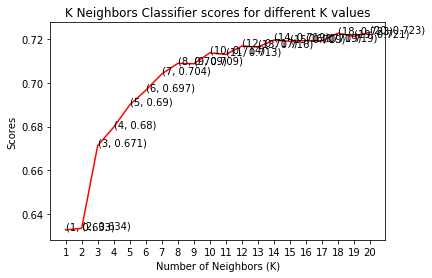

In [26]:
plt.plot([k for k in range(1, 21)], knn_scores, color = 'red')
for i in range(1,21):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1].round(3)))
plt.xticks([i for i in range(1, 21)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('K Neighbors Classifier scores for different K values')

here the max accuracy achieved is 72.3% at k=20

#### RANDOM FOREST

In [108]:
from sklearn.ensemble import RandomForestClassifier

depth = 10  #@param {type: "slider", min: 0, max: 100}
estimators = 201  #@param {type: "slider", min: 100, max: 1000}
rf = RandomForestClassifier(n_estimators=estimators,n_jobs=-1,random_state=0,max_depth=depth)
rf.fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, Y_train)))
print("Accuracy on val set: {:.3f}".format(rf.score(X_val, Y_val)))

Accuracy on training set: 0.759
Accuracy on val set: 0.734


In [109]:
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, Y_test)))

Accuracy on test set: 0.737


#### MLP 

In [110]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42,verbose=1,hidden_layer_sizes=(15, 15),max_iter=200,tol=0.0001,solver='adam')
mlp.fit(X_train, Y_train)
print("Accuracy on training set: {:.5f}".format(mlp.score(X_train, Y_train)))
print("Accuracy on val set: {:.5f}".format(mlp.score(X_val, Y_val)))

Iteration 1, loss = 0.61622702
Iteration 2, loss = 0.55365668
Iteration 3, loss = 0.54643473
Iteration 4, loss = 0.54363116
Iteration 5, loss = 0.54163754
Iteration 6, loss = 0.54058406
Iteration 7, loss = 0.53972514
Iteration 8, loss = 0.53878566
Iteration 9, loss = 0.53822363
Iteration 10, loss = 0.53778196
Iteration 11, loss = 0.53710965
Iteration 12, loss = 0.53653916
Iteration 13, loss = 0.53616357
Iteration 14, loss = 0.53575661
Iteration 15, loss = 0.53541320
Iteration 16, loss = 0.53511772
Iteration 17, loss = 0.53481929
Iteration 18, loss = 0.53453670
Iteration 19, loss = 0.53434850
Iteration 20, loss = 0.53424974
Iteration 21, loss = 0.53416333
Iteration 22, loss = 0.53399014
Iteration 23, loss = 0.53370243
Iteration 24, loss = 0.53357669
Iteration 25, loss = 0.53340908
Iteration 26, loss = 0.53311119
Iteration 27, loss = 0.53318018
Iteration 28, loss = 0.53285373
Iteration 29, loss = 0.53281198
Iteration 30, loss = 0.53261546
Iteration 31, loss = 0.53244787
Iteration 32, los

In [111]:
print("Accuracy on test set: {:.5f}".format(mlp.score(X_test, Y_test)))

Accuracy on test set: 0.73810


### SVC

In [112]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
svc = svm.SVC(kernel='rbf')
svc.fit(X_train_scaled, Y_train)
print("****Results after scaling****")
print("Accuracy on training set: {:.5f}".format(svc.score(X_train_scaled, Y_train)))
print("Accuracy on test set: {:.5f}".format(svc.score(X_test_scaled, Y_test)))

****Results after scaling****
Accuracy on training set: 0.73609
Accuracy on test set: 0.73334


#### DECISION TREE

In [89]:
from sklearn.tree import DecisionTreeClassifier
#@title max depth
#@markdown max depth.


depth = 7  #@param {type: "slider", min: 0, max: 100}

tree = DecisionTreeClassifier(max_depth=depth,random_state=0)
tree.fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, Y_train)))
print("Accuracy on val set: {:.3f}".format(tree.score(X_val, Y_val)))

Accuracy on training set: 0.741
Accuracy on val set: 0.729


In [72]:
print("Feature importances:\n{}".format(tree.feature_importances_))


Feature importances:
[0.11839269 0.00218681 0.00965833 0.0186948  0.74854058 0.00635565
 0.0027837  0.00218787 0.00868377 0.         0.0028553  0.06816061
 0.0012617  0.00211195 0.00812624]


#### varying number of max_features

In [43]:
dt_scores = []
for i in range(1,10):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    dt_classifier.fit(X_train, Y_train)
    dt_scores.append(dt_classifier.score(X_test, Y_test))

Text(0.5,1,'Decision Tree Classifier scores for different number of maximum features')

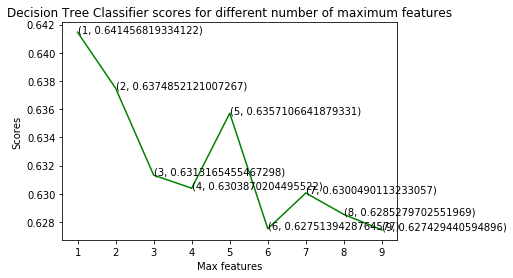

In [44]:

plt.plot([i for i in range(1, 10)], dt_scores, color = 'green')
for i in range(1, 10):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, 10)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

## ENSEMBLE LEARNING

### 1.  MAX VOTING 1

In [90]:
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression(random_state=1)
model2 = DecisionTreeClassifier(random_state=1,max_depth=5)
model3 = KNeighborsClassifier(n_neighbors=20)
model4 = MLPClassifier(random_state=1)
model5 = RandomForestClassifier(n_estimators=100, random_state=1,max_depth=20)
modelv1 = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('knn', model3), ('mlp', model4),('rf', model5)], voting='hard')
modelv1.fit(X_train,Y_train)
print('Score of voting Classifier')
print('train score ',modelv1.score(X_train,Y_train))

print('val score ',modelv1.score(X_val,Y_val))

Score of voting Classifier


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


train score  0.7616868171115638
val score  0.7294179894179894


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
print("Accuracy on test set: {:.3f}".format(modelv1.score(X_test, Y_test)))

Accuracy on test set: 0.741


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### MAX VOTING 2

In [301]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
model1 = GradientBoostingClassifier(random_state=1,max_depth=5,learning_rate=0.1)
model2 = DecisionTreeClassifier(random_state=1)
model3 = KNeighborsClassifier()
model4 = MLPClassifier(random_state=1)
model5 = RandomForestClassifier(n_estimators=100, random_state=1,max_depth=10)
model6 = XGBClassifier(n_estimators=100, random_state=1,learning_rate=0.01)
modelv2  = VotingClassifier(estimators=[('gb', model1),('knn', model3), ('mlp', model4),('rf', model5),('xg', model6)], voting='hard',n_jobs=-1)
modelv2.fit(X_train,Y_train)
print('Score of voting Classifier')
print('train score ',modelv2.score(X_train,Y_train))

print('val score ',modelv2.score(X_val,Y_val))

C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\externals\joblib\pool.py:438: UserWarning: Failed to clean temporary folder: C:\Users\sreej\AppData\Local\Temp\joblib_memmaping_pool_8736_2524019415472
  warnings.warn("Failed to clean temporary folder: %s" % folder_path)


Score of voting Classifier


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


train score  0.753587692778692
val score  0.7353436399816318


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### STACKING 

#### MODEL 1

In [187]:
models = [
    KNeighborsClassifier(n_neighbors=20,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=10),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=15)
]



#### MODEL 2

In [0]:
models = [
    
    LogisticRegression(n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=10),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3)
]


#### LAYER 0

In [111]:
from vecstack import stacking
S_train, S_test = stacking(models,                   
                           X_train, Y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=3, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

NameError: name 'models' is not defined

#### LAYER 1

In [189]:
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3)
    
model = model.fit(S_train, Y_train)
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_pred,Y_test))

Final prediction score: [0.73297318]


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### BAGGING

In [0]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
cart = RandomForestClassifier()
num_trees = 100
model_bag = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=7,verbose=1)
results = model_selection.cross_val_score(model_bag, X_train, Y_train, cv=kfold)
print(results.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/

0.7128746220509822


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


### BOOSTING

#### GRADIENT BOOSTING

In [75]:
from sklearn.ensemble import GradientBoostingClassifier
depth = 5  #@param {type: "slider", min: 0, max: 100}
gb = GradientBoostingClassifier(random_state=0,max_depth=depth)
gb.fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(X_train, Y_train)))
print("Accuracy on val set: {:.3f}".format(gb.score(X_val, Y_val)))

Accuracy on training set: 0.750
Accuracy on val set: 0.735


In [76]:
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, Y_test)))

Accuracy on val set: 0.733


#### ADABOOST

In [184]:
from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 70
kfold = model_selection.KFold(n_splits=10, random_state=seed)
aboost = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(aboost, X_train, Y_train, cv=kfold)
print(results.mean())


0.7246393312766009


In [185]:
aboost.fit(X_train, Y_train)
print(model.score(X_train, Y_train))
print(model.score(X_val, Y_val))

C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7451991197130023
0.7286868443265404


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### XGBOOST

In [186]:
from vecstack import stacking
from xgboost import XGBClassifier
seed = 7
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=seed)
xgb = XGBClassifier(n_estimators=num_trees, random_state=seed,learning_rate=0.1)
results = model_selection.cross_val_score(xgb, X_train, Y_train, cv=kfold)
print(results.mean())

C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

0.7289502377199817


C:\Users\sreej\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### AUC score and precision recall graph

In [112]:
def plotting(true,pred):
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    precision,recall,threshold = precision_recall_curve(true,pred[:,1])
    ax[0].plot(recall,precision,'g--')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title("Average Precision Score : {}".format(average_precision_score(true,pred[:,1])))
    fpr,tpr,threshold = roc_curve(true,pred[:,1])
    ax[1].plot(fpr,tpr)
    ax[1].set_title("AUC Score is: {}".format(auc(fpr,tpr)))
    ax[1].plot([0,1],[0,1],'k--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    


<Figure size 432x288 with 0 Axes>

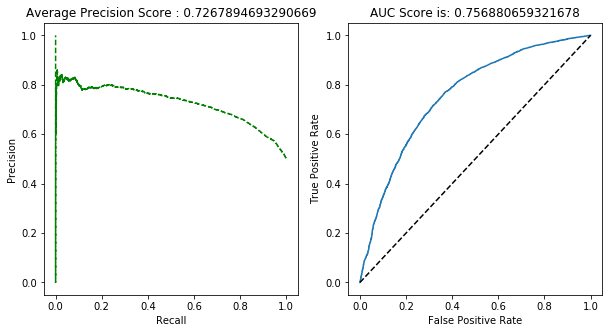

In [191]:
plt.figure()
plotting(Y_test,gaussian.predict_proba(X_test))


<Figure size 432x288 with 0 Axes>

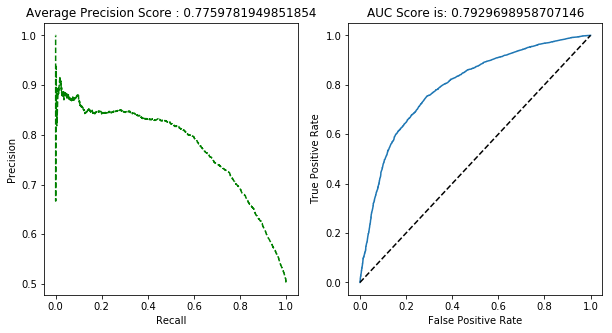

In [192]:
plt.figure()
plotting(Y_test,aboost.predict_proba(X_test))